# Семинар 3

## Что мы сегодня узнаем?

- познакомимся с новым алгоритмом машинного обучения - решающим деревом

- напишем код для разбиения вершины

- узнаем про случайный лес

- узнаем про кросс-валидацию

### Решающие деревья
<img src='tree_example.png'>
Сами по себе решающие деревья используются в машинном обучении относительно редко, однако очень распространены методы, основанные на их композиции - ансамблях (Random Forest, XGBoost, LightGBM).

##### Плюсы:

- интерпретируемость
- способность выделить самые важные признаки
- отсутствие потребности в серьезной предобработке данных

##### Минусы:

- склонность к переобучению
- неустойчивость - небольшие изменения в данных могут привести к сильному изменению в структуре дерева
- эвристичность обучения - как оптимизировать?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

%matplotlib inline

### Переобучение на примере задачи регрессии

In [2]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

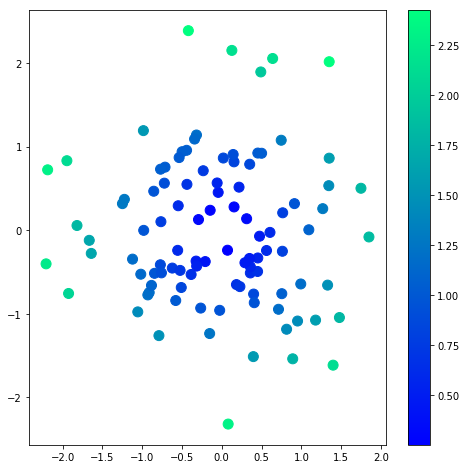

In [3]:
np.random.seed(13)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='winter')
plt.colorbar()
plt.show()

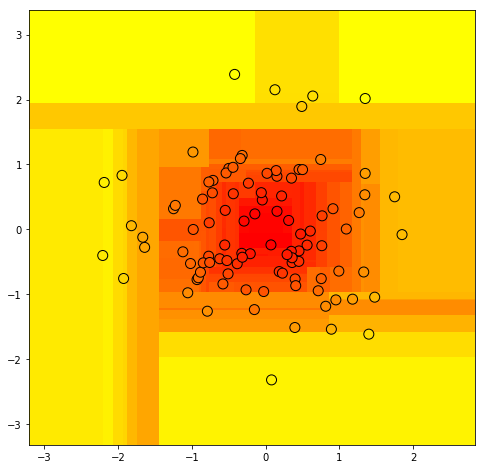

In [4]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=13, )
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='autumn', edgecolor='k')
plt.show()

Посмотрим, как будет выглядеть разделение плоскости в зависимости от максимальной глубины дерева и минимального числа объектов в листе.

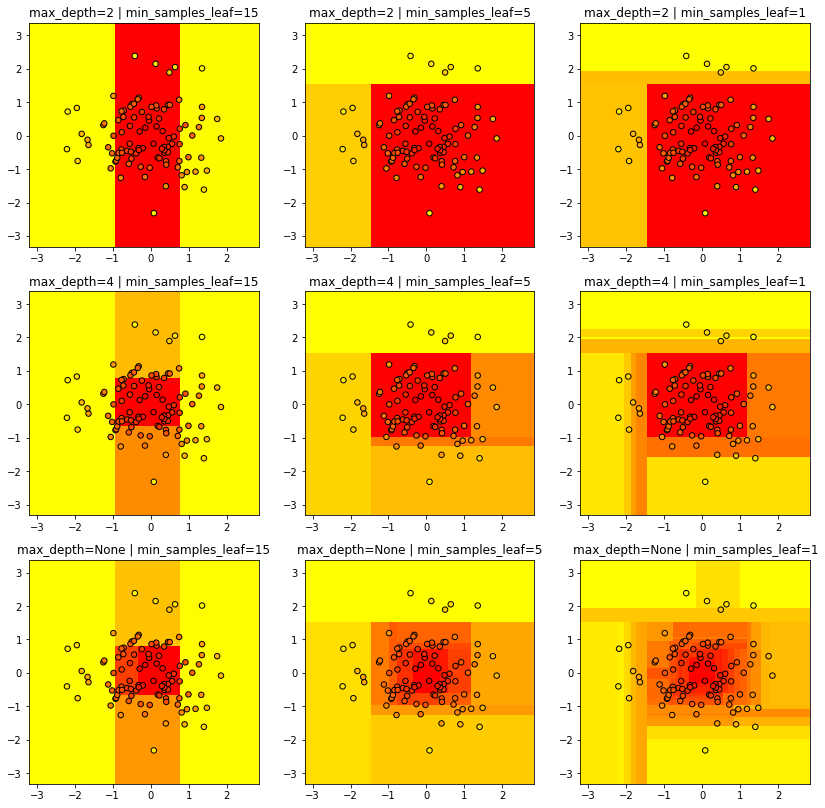

In [22]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='autumn')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='autumn', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

### Неустойчивость
Посмотрим, как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки исходной выборки.

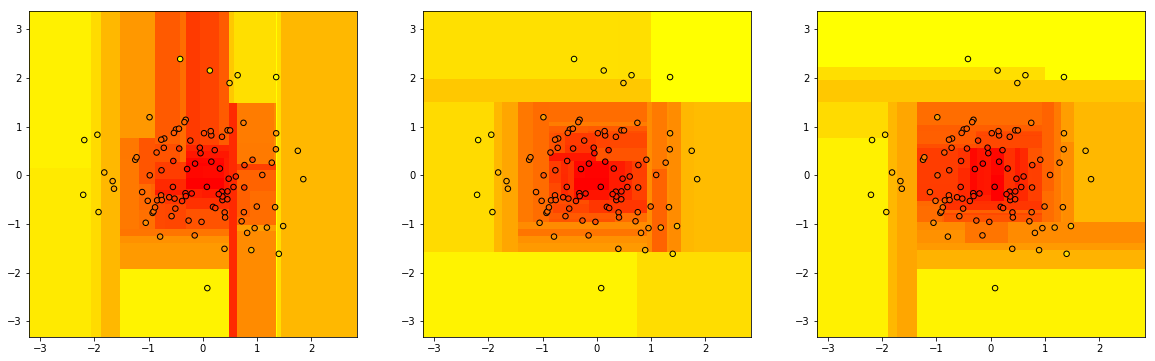

In [5]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=13)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='autumn')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='autumn', edgecolor='k')

### Практика

In [6]:
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [7]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [8]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [16]:
boston['data'].shape

(506, 13)

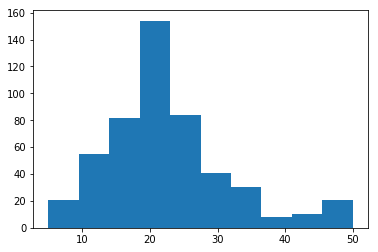

In [9]:
plt.hist(boston['target'])
plt.show()

In [10]:
data_train, data_test, y_train, y_test = train_test_split(boston['data'], boston['target'], random_state=13)

In [11]:
X_train = pd.DataFrame(data_train, columns=boston['feature_names'])
X_test = pd.DataFrame(data_test, columns=boston['feature_names'])
X_train['target'] = y_train

In [12]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.17171,25.0,5.13,0.0,0.453,5.966,93.4,6.8185,8.0,284.0,19.7,378.08,14.44,16.0
1,0.12083,0.0,2.89,0.0,0.445,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
2,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26,20.4
3,0.25199,0.0,10.59,0.0,0.489,5.783,72.7,4.3549,4.0,277.0,18.6,389.43,18.06,22.5
4,0.10793,0.0,8.56,0.0,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00,21.7


In [13]:
X_train.shape, X_test.shape

((379, 14), (127, 13))

# Как это работает?

$R_m$ - множество объектов в разбиваемой вершине, $i$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Качество (чем выше качество, тем лучше):

$$
Q(R_m, i, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r)
$$

* $R_m$ - множество объектов в корне рассматриваемого поддерева,
* $R_\ell$ - множество объектов в левом поддереве,
* $R_r$ - множество объектов в правом поддереве.

* $|R_\ell|$ - количество объектов в левом поддереве
* $|R_r|$ - количество объектов в правом поддереве


* $H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.


_Вопрос. Что мы хотим сделать с $H(R)$ - минимизировать или максимизировать? А $Q(R_m, i, t)$?_

_Вопрос. Что можно использовать в качестве критерия информативности для регрессии? *А для классификации?_

# Task 1

Давайте реализуем подсчет качества разбиения

In [14]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.17171,25.0,5.13,0.0,0.453,5.966,93.4,6.8185,8.0,284.0,19.7,378.08,14.44,16.0
1,0.12083,0.0,2.89,0.0,0.445,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
2,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26,20.4
3,0.25199,0.0,10.59,0.0,0.489,5.783,72.7,4.3549,4.0,277.0,18.6,389.43,18.06,22.5
4,0.10793,0.0,8.56,0.0,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00,21.7


In [74]:
def H(R):
    # для задачи регрессии критерий информативности -- это разброс значений 
    # целевой переменной внутри множества R
    return R['target'].var(ddof=0)

def split_node(R_m, feature, t):
    # эта функция должна делать множество R_m
    # на множество R_l, где R_m[feature] <= t
    # и на множество R_r, где R_m[feature] > t
    # твой код тут # (つ▀¯▀)つ
    return R_l, R_r

def quality(R_m, feature, t):
    # здесь получаем на вход вершину, признак и его значение,
    # по которому делать разбиение;
    # далее возвращаем Q, рассчитанное по формуле
    # твой код тут # (つ▀¯▀)つ
    return Q

In [25]:
# Solution
def H(R):
    return R['target'].var(ddof=0)

def split_node(R_m, feature, t):
    R_l = R_m[R_m[feature] <= t]
    R_r = R_m[R_m[feature] > t]
    return R_l, R_r

def quality(R_m, feature, t):
    R_l, R_r = split_node(R_m, feature, t)
    Q = H(R_m) - len(R_l) / len(R_m) * H(R_l) - len(R_r) / len(R_m) * H(R_r)
    return Q

# Task 2

_Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку._

In [21]:
Q_arr = []
for i in range(5):
    Q_arr.append(i*i)
Q_arr

[0, 1, 4, 9, 16]

In [ ]:
def get_optimal_split(R_m, feature):
    # your code here
    # Нужно для каждого признака
    # перебрать все возможные его значения 
    # и для каждого такого значения посчитать Q
    # оптимальным будет значение признака с максимальным Q
    return t, Q_arr

In [23]:
# Solution
def get_optimal_split(R_m, feature):
    Q_arr = []
    R_m_sorted = sorted(R_m[feature])
    for val in R_m_sorted[:-1]:
        Q_arr.append(quality(R_m, feature, val))
    Q_arr = np.array(Q_arr)
    t = R_m_sorted[Q_arr.argmax()]
    return t, Q_arr

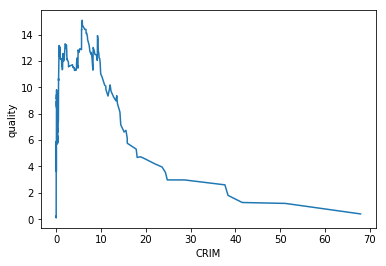

In [26]:
t, Q_arr = get_optimal_split(X_train, 'CRIM')
plt.plot(sorted(X_train['CRIM'])[:-1], Q_arr)
plt.xlabel('CRIM')
plt.ylabel('quality')
plt.show()

In [ ]:
def accuracy(a,b):
    return len(a[a==b])/len(a)

# Используем готовые решения

Но сначала немного про метрику среднеквадратичное отклонение это:

$${\displaystyle \operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}}$$ 
* $Y_i$ -- истинное значение
* $\hat {Y_{i}}$ -- предсказанное значение

**Итак, чем меньше MSE, тем лучше.**

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
dt = DecisionTreeRegressor()

In [29]:
X_train.drop(labels=['target'], inplace=True, axis=1)

In [30]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [31]:
prediction = dt.predict(X_test)

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
mean_squared_error(y_test, prediction)

14.13275590551181

# Ансамблирование

Уместна история о слепых мудрецах, каждый из которых описывает слона по-своему.

<img src="mudr.jpeg" width=700>

# Bagging

- метод ансамблирования базовых алгоритмов, при котором каждый отдельный алгоритм обучается на случайной подвыборке с возвращением, затем предсказания алгоритмов усредняются.

- сэмплирование из выборки с возвращением называется **бутстрепом**, поэтому альтернативное название метода беггинга -- *bootstrap aggregation*.

# Task 3
### (опциональная часть, если успеем)

Реализуйте случайные разбиения датасета и случайный лес

In [75]:
# твой код тут # (つ▀¯▀)つ

### Беггинг на деревьях

In [35]:
from sklearn.ensemble import BaggingRegressor

In [36]:
clf = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                       n_estimators=100)
clf.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [39]:
predictions = clf.predict(X_test)

In [40]:
mean_squared_error(y_test, predictions)

11.918528724409446

# Кросс валидация!

<img src="crossval.png" width="400" align="center">

In [41]:
# реализация k-fold cv со стратификацией по параметру y
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

kfold_iterator = KFold(n_splits=3, random_state=42)
X, y = boston['data'], boston['target']
for train_index, test_index in kfold_iterator.split(X,y):
    print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [169 170 171 172 173] TEST: [0 1 2 3 4]
TRAIN: [0 1 2 3 4] TEST: [169 170 171 172 173]
TRAIN: [0 1 2 3 4] TEST: [338 339 340 341 342]


In [44]:
clf

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [45]:
cross_val_score(clf, X,y, cv=3).mean()

0.5542319982653324

# Task 3

С помощью кросс-валидации на 5-ти фолдах посчитайте метрики для классификатора с Bagging и для дерева решений

In [ ]:
# твой код тут # (つ▀¯▀)つ